<a href="https://colab.research.google.com/github/wantepim84/NetworkX/blob/main/NetworkX_Ch10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Working With Space Data
# Load data file into network (airport flights example)
from pathlib import Path
data_dir = Path('/content/carrier.csv')
G_air = nx.Graph()
with open(data_dir) as f:
    # Skip header
    next(f)
    # Loop through data rows
    for row in f:
        count, v, w, year, month = row.strip().split(',')
        count = int(count)
        if count == 0 or v == w:
            continue
        try:
            G_air.edges[v, w]['count'] += count
        except KeyError:
            G_air.add_edge(v, w, count=count)

In [3]:
# Load latitude and longitude of airports
data_dir2 = Path('/content/GlobalAirportDatabase.txt')
airport_lat_long = {}
with open(data_dir2) as f:
    for row in f:
        columns = row.strip().split(':')
        code = columns[1]
        lat = float(columns[14])
        long = float(columns[15])
        airport_lat_long[code] = (lat, long)

In [4]:
# Add latitude and longitude to nodes, limit nodes to continental US
for v in list(G_air.nodes()):
    try:
        lat, long = airport_lat_long[v]
        if long == 0 or long < -128.6 or lat == 0 or lat < 23.5:
            G_air.remove_node(v)
            continue
        G_air.nodes[v]['lat'] = lat
        G_air.nodes[v]['long'] = long
    except KeyError:
        G_air.remove_node(v)

In [5]:
# Finding the largest connected component
G_air = nx.subgraph(G_air, max(nx.connected_components(G_air), key=len))

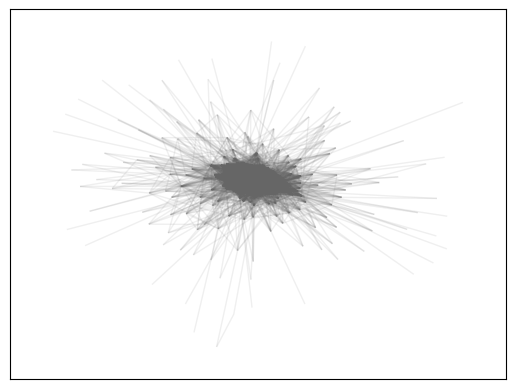

In [6]:
# Visualize the network
nx.draw_networkx(
    G_air, node_size=0, with_labels=False, edge_color='#666666', alpha=0.1)

In [7]:
# Create geographc position
import math
pos = dict()
for v in G_air.nodes:
    long = G_air.nodes[v]['long']
    lat = G_air.nodes[v]['lat']
    pos[v] = ((long + 90) * math.cos(2 * math.pi * lat / 360), lat)

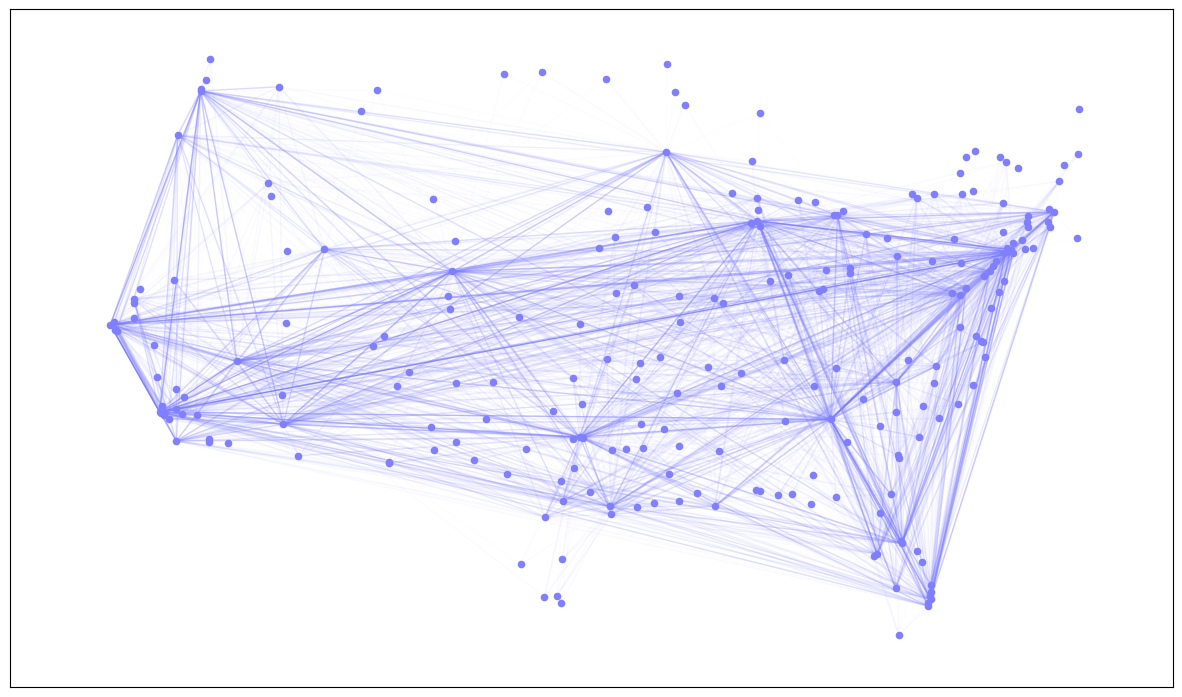

In [8]:
# Draw network geographically
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(1, 1, 1)
max_weight = max([G_air.edges[e]['count'] for e in G_air.edges])
nx.draw_networkx_nodes(G_air, pos=pos, node_color='#7f7fff', node_size=20)
for e in G_air.edges:
    alpha = G_air.edges[e]['count'] / max_weight
    nx.draw_networkx_edges(
        G_air, pos=pos, edgelist=[e], edge_color='#7f7fff', alpha=alpha, arrows=False)
ax.set_aspect(1)

In [9]:
# Gravity model for air travel
def haversine(q, p):
    'Calculate the distance between two (lat, long) points'
    R_km = 6371
    theta1 = q[1] * math.pi / 180
    phi1 = q[0] * math.pi / 180
    theta2 = p[1] * math.pi / 180
    phi2 = p[0] * math.pi / 180
    dphi = phi2 - phi1
    dtheta = theta2 - theta1
    a = (math.sin(dphi/2) * math.sin(dphi/2)
        + (math.cos(phi1) * math.cos(phi2)
           * math.sin(dtheta/2) * math.sin(dtheta/2)))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R_km * c
    return d

In [10]:
# Calculate distances
for v, w in G_air.edges:
    p_v = (G_air.nodes[v]['lat'], G_air.nodes[v]['long'])
    p_w = (G_air.nodes[w]['lat'], G_air.nodes[w]['long'])
    G_air.edges[v, w]['distance'] = haversine(p_v, p_w)

In [11]:
# Calculate node degrees
degree = G_air.degree(weight='count')
nx.set_node_attributes(G_air, dict(degree), 'degree')

In [12]:
# Calculate coefficient for each edge
g_list = []
for v in G_air.nodes:
    for w in G_air.nodes:
        if v >=w:
            # Only count each edge once
            continue
        try:
            count = G_air.edges[v, w]['count']
        except KeyError:
            # If edge doesn't exist, add a 0
            g_list.append(0)
            continue
        distance = G_air.edges[v, w]['distance']
        v_degree = G_air.nodes[v]['degree']
        w_degree = G_air.nodes[w]['degree']
        g_list.append(count * distance**2 / v_degree / w_degree)

In [13]:
# Calculate geometric mean of coefficients
g = 10**(sum([math.log10(g) for g in g_list if g > 0]) / len(g_list))

In [14]:
# Calculate expected weight and surplus
for v, w in G_air.edges:
    if v == w:
        continue
    count = G_air.edges[v, w]['count']
    # Calculate expected weight
    expected = (
        g * G_air.nodes[v]['degree']
        * G_air.nodes[w]['degree']
        / G_air.edges[v, w]['distance']**2)
    G_air.edges[v, w]['expected'] = expected
    # Calculate residual
    G_air.edges[v, w]['residual'] = count - expected
    G_air.edges[v, w]['log_residual'] = math.log10(count) - math.log10(expected)

In [15]:
# Residual network
# Create residual graph
residual_edges = [e for e in G_air.edges if G_air.edges[e]['log_residual'] > 0]
G_residual = G_air.edge_subgraph(residual_edges)
# Keep the largest connected component
G_residual = nx.subgraph(G_residual, max(nx.connected_components(G_residual), key=len))

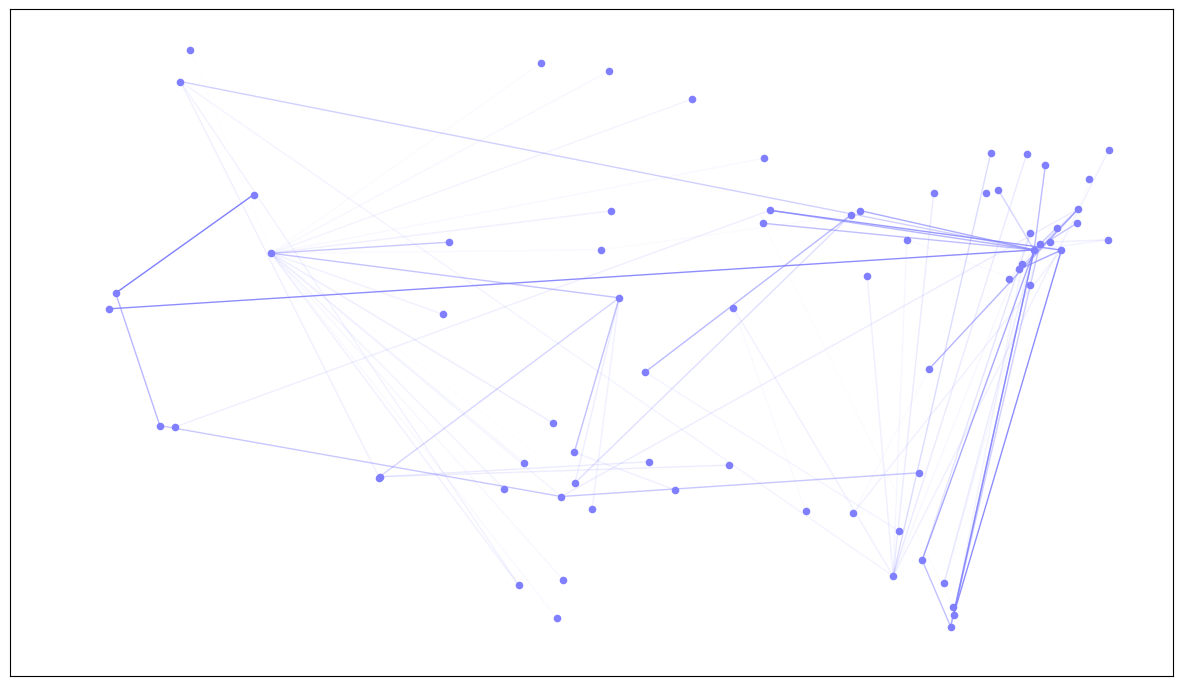

In [16]:
# Visualisation of residual network
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(1, 1, 1)
max_weight = max([G_residual.edges[e]['log_residual'] for e in G_residual.edges])
nx.draw_networkx_nodes(G_residual, pos=pos, node_color='#7f7fff', node_size=20)
for e in G_residual.edges:
    alpha = G_residual.edges[e]['log_residual'] / max_weight
    nx.draw_networkx_edges(
        G_residual, pos=pos, edgelist=[e], edge_color='#7f7fff', alpha=alpha, arrows=False)
ax.set_aspect(1)

In [17]:
# Netowrk Properties - use average_clustering
nx.average_clustering(G_air)

0.6577002515250526

In [18]:
nx.average_clustering(G_air)

0.6577002515250526

In [20]:
# Working With Time Data
data_dir3 = Path('/content/wikilinks.csv')
G_wiki = nx.read_edgelist(
    str(data_dir3),
    data=[('begin', int), ('end', int)],
    create_using=nx.MultiGraph)
len(G_wiki)

43509

In [21]:
# Create a snapshot of the network at a particular time, specified by the date parameter
import datetime
import time
def get_snapshot(G, date):
    # Convert date to integer timestamp
    dt = datetime.datetime.strptime(date, '%Y-%m-%d')
    timestamp = time.mktime(dt.timetuple())
    # Find edges that existed during timestamp
    snapshot_edges = []
    for e in G.edges:
        if G.edges[e]['begin'] <= timestamp and G.edges[e]['end'] >= timestamp:
            snapshot_edges.append(e)
    # Create network from edges
    return nx.Graph(G.edge_subgraph(snapshot_edges))

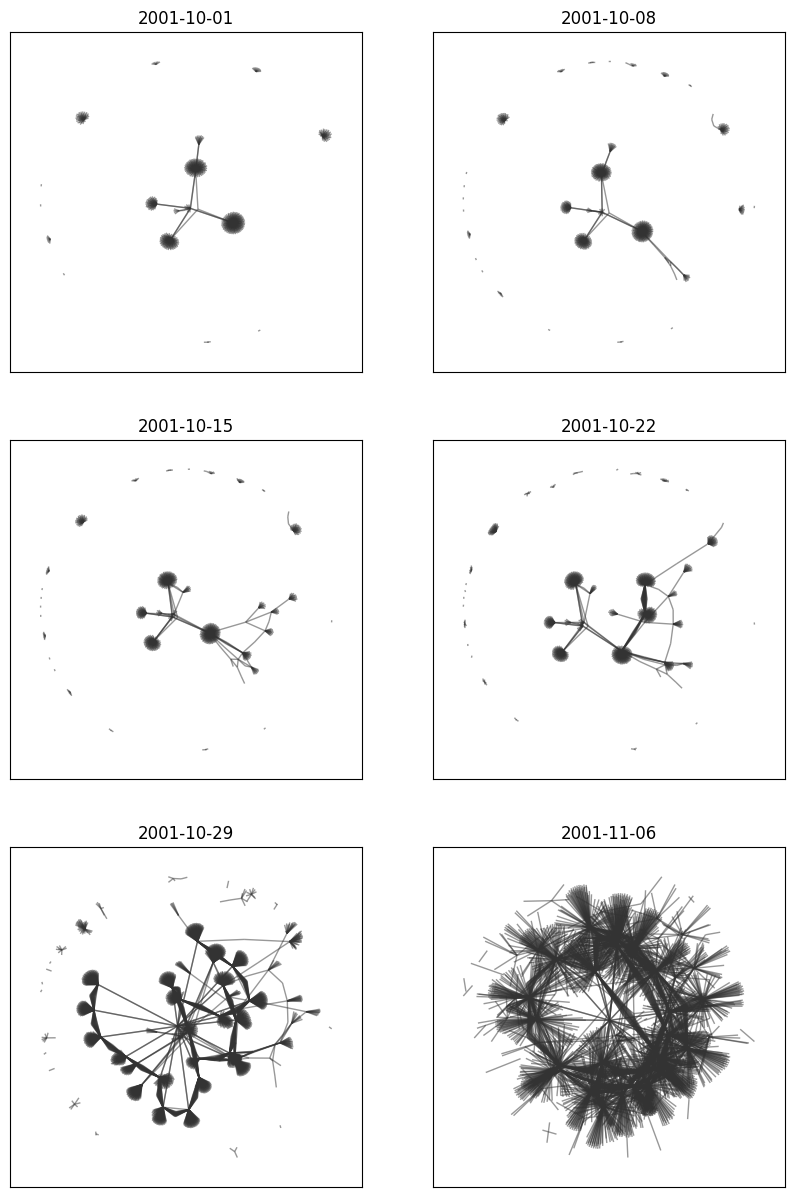

In [22]:
# Visualize the network at different times over the course of six months
# Specify the dates to visualize
dates = [
    '2001-10-01',
    '2001-10-08',
    '2001-10-15',
    '2001-10-22',
    '2001-10-29',
    '2001-11-06',
]

# Create a figure
plt.figure(figsize=(10, 15))
# Visualize the network for each date
pos = None
for i, date in enumerate(reversed(dates)):
    # Get a snapshot of the network
    G = get_snapshot(G_wiki, date)
    # Create a subplot
    plt.subplot(3, 2, 6 - i)
    plt.title(date)
    # Calculate the layout
    pos = nx.spring_layout(G, pos=pos, k=0.09)
    # Visualize
    nx.draw_networkx(
        G, pos=pos, alpha=0.5, edge_color='#333333', node_size=0, with_labels=False)

In [23]:
# The evolution of network properties
# Create snapshot
year = 2001
month = 10
clustering = []
for i in range(24):
    date = '{}-{}-01'.format(year, month)
    G = get_snapshot(G_wiki, date)
    clustering.append(nx.average_clustering(G))
    # Update month and year
    month += 1
    if month > 12:
        month -= 12
        year += 1

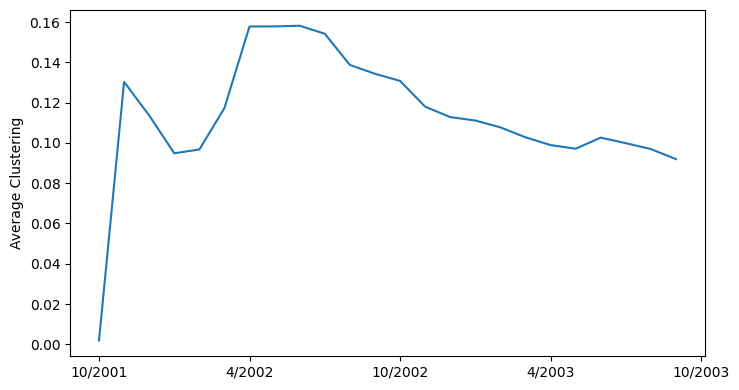

In [24]:
# Create figure
plt.figure(figsize=(7.5, 4))
ax = plt.subplot(1, 1, 1)
for spine in ax.spines.values():
    spine.set_visible(True)
# Plot clustering over time
plt.plot(clustering)
# Add labels and ticks
plt.ylabel('Average Clustering')
plt.xticks(
    [0, 6, 12, 18, 24],
    ['10/2001', '4/2002', '10/2002', '4/2003', '10/2003'])
plt.tight_layout()